In [1]:
# Example of maximum-likelihood fit with iminuit.
# pdf is a mixture of Gaussian (signal) and exponential (background),
# truncated in [xMin,xMax].
# G. Cowan / RHUL Physics / November 2020

import numpy as np
import scipy.stats as stats
from scipy.stats import truncexpon
from scipy.stats import truncnorm
from scipy.stats import chi2
from iminuit import Minuit
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

In [2]:
# define pdf and generate data
np.random.seed(seed=1234567)        # fix random seed
theta = 0.2                         # fraction of signal
mu = 10.                            # mean of Gaussian
sigma = 2.                          # std. dev. of Gaussian
xi = 5.                             # mean of exponential
xMin = 0.
xMax = 20.

def f(x, par):
    theta   = par[0]
    mu      = par[1]
    sigma   = par[2]
    xi      = par[3]
    fs = stats.truncnorm.pdf(x, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    fb = stats.truncexpon.pdf(x, b=(xMax-xMin)/xi, loc=xMin, scale=xi)
    return theta*fs + (1-theta)*fb

In [3]:
numVal = 200
xData = np.empty([numVal])
for i in range (numVal):
    r = np.random.uniform();
    if r < theta:
        xData[i] = stats.truncnorm.rvs(a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    else:
        xData[i] = stats.truncexpon.rvs(b=(xMax-xMin)/xi, loc=xMin, scale=xi)

# Put data into a histogram
numBins=40
xHist, bin_edges = np.histogram(xData, bins=numBins, range=(xMin, xMax))
binSize = bin_edges[1] - bin_edges[0]

In [4]:
# Function to be minimized
def chi2LS(par):
    xMid = bin_edges[:numBins] + 0.5*binSize
    binProb = f(xMid, par)*binSize
    nu = numVal*binProb
    sigma = np.sqrt(nu)
    z = (xHist - nu)/sigma
    return np.sum(z**2)
    
def chi2M(par):
    xMid = bin_edges[:numBins] + 0.5*binSize
    binProb = f(xMid, par)*binSize
    nu = numVal*binProb
    lnL = 0.
    for i in range(len(xHist)):
        if xHist[i] > 0.:
            lnL += xHist[i]*np.log(nu[i]/xHist[i])
    
    return -2.*lnL


In [5]:
# Initialize Minuit and set up fit:
#     initial parameter values are guesses,
#     error values set initial step size in search algorithm,
#     limit_param to set limits on parameters (needed here to keep pdf>0),
#     fix_param=True to fix a parameter,
#     errordef=1.0 means errors correspond to chi2 = chi2min + 1,
#     pedantic=False to turn off verbose messages.

parin   = np.array([theta, mu, sigma, xi])      # initial values (here equal true)
parname = ['theta', 'mu', 'sigma', 'xi']
parstep = np.array([0.1, 1., 1., 1.])           # initial setp sizes
parfix  = [False, True, True, False]            # change these to fix/free parameters
parlim  = [(0.,1), (None, None), (0., None), (0., None)]
m = Minuit.from_array_func(chi2M, parin, parstep, name=parname,
    limit=parlim, fix=parfix, errordef=1.0, pedantic=False)

In [6]:
# do the fit, get errors, extract results
m.migrad()                                             # minimize -logL
parhat = m.np_values()                                 # estimates
sigma_parhat = m.np_errors()                           # standard deviations
cov = m.np_matrix(skip_fixed=True)                     # covariance matrix
rho = m.np_matrix(skip_fixed=True, correlation=True)   # correlation coeffs.
npar = len(m.np_values())
nfreepar = len(cov[0])
    
npar = len(m.np_values())
print(r'par index, name, estimate, standard deviation:')
for i in range(npar):
    if not(m.is_fixed(i)):
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(parhat[i]), " +/- ", "{:.6f}".format(sigma_parhat[i]))

print()
print(r'free par indices, covariance, correlation coeff.:')
for i in range(nfreepar):
    for j in range(nfreepar):
        print(i, j, "{:.6f}".format(cov[i,j]), "{:.6f}".format(rho[i,j]))

par index, name, estimate, standard deviation:
   0 theta       =  0.201533  +/-  0.052956
   3 xi          =  5.148508  +/-  0.651156

free par indices, covariance, correlation coeff.:
0 0 0.002821 1.000000
0 1 -0.018494 -0.534693
1 0 -0.018494 -0.534693
1 1 0.424135 1.000000


In [7]:
# Retrieve minimized chi-squared, etc.
ndof = numBins - nfreepar - 1           # for multinomial
chisq = chi2M(parhat)
print ("chisq = ", chisq, ",     ndof = ", ndof)
pval = chi2.sf(chisq, ndof)
print ("pval = ", pval)

chisq =  35.269550110496475 ,     ndof =  37
pval =  0.5503255503742248


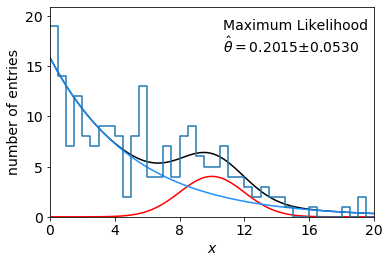

<Figure size 432x288 with 0 Axes>

In [8]:
# Plot fit
fig, ax = plt.subplots(1,1)
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
yMin = 0.
yMax = np.max(xHist)*1.1
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
plt.xticks(np.arange(xMin, xMax+1, 4.0))
xCurve = np.linspace(xMin, xMax, 100)
yCurve = f(xCurve, parhat)*numVal*binSize
sig_parhat = np.copy(parhat)
sig_parhat[0] = 1.
bkg_parhat = np.copy(parhat)
bkg_parhat[0] = 0.
sigCurve = f(xCurve, sig_parhat)*numVal*binSize*parhat[0]
bkgCurve =f(xCurve, bkg_parhat)*numVal*binSize*(1.-parhat[0])
plt.plot(xCurve, yCurve, color='black')
plt.plot(xCurve, sigCurve, color='red')
plt.plot(xCurve, bkgCurve, color='dodgerblue')

# Plot data histogram
binLo, binHi = bin_edges[:-1], bin_edges[1:]
xPlot = np.array([binLo, binHi]).T.flatten()
yPlot = np.array([xHist, xHist]).T.flatten()
plt.plot(xPlot, yPlot)
plt.xlabel(r'$x$')
plt.ylabel(r'number of entries')
plt.figtext(0.55, 0.8, r'Maximum Likelihood')
plt.figtext(0.55, 0.72, r'$\hat{\theta} = $' + f'{parhat[0]:.4f}' +
            r'$\pm$' + f'{sigma_parhat[0]:.4f}')
plt.show()
plt.savefig("histFit.pdf", format='pdf')